In [179]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [180]:
# Cargar el archivo .mat
data = loadmat('../../datos/dataicann.mat')

# Mostrar las claves del diccionario cargado
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'z', 'nom', 'NombresVariables'])

In [181]:
muestras = data['z']
etiquetas = data['nom']
nombresCaracteristicas = data['NombresVariables']

In [182]:
# Concatenar todas las muestras en una matriz bidimensional
X = np.vstack([np.vstack(muestra) for muestra in muestras[0]])

# Crear un vector de etiquetas con el mismo número de filas que muestras_concatenadas
etiq_str = np.array([str(etiquetas[0][k][0]) for k in range(etiquetas.shape[1])])
etiq_str = np.array([etiqueta.split('.')[0] for etiqueta in etiq_str])
Y = np.repeat(etiq_str, [muestra.shape[0] for muestra in muestras[0]])

print(f"La matriz de datos de diagnóstico del motor tiene {X.shape[0]} muestras y {X.shape[1]} características")
print(f"El vector de etiquetas tiene {Y.shape[0]} elementos")

La matriz de datos de diagnóstico del motor tiene 209920 muestras y 5 características
El vector de etiquetas tiene 209920 elementos


In [183]:
etiq_str

array(['asim0g', 'asim0gfallor', 'cap0ohm', 'cap10ohm', 'cap15ohm',
       'cap20ohm', 'cap5ohm', 'capvarohm', 'capvarohm2'], dtype='<U12')

In [184]:
# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar el vector de etiquetas
Y_int = label_encoder.fit_transform(Y)

print(Y_int)

[0 0 0 ... 8 8 8]


# Extracción de características

Para eliminar el offset de la señal, se normaliza.

In [185]:
# Crear un objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar la matriz X
Xn = scaler.fit_transform(X)

In [186]:
fm = 5000 # Frecuencia de muestreo
tm = 1/fm # Tiempo de muestreo
Q = X.shape[0] # Número de muestras
ff = np.arange(0, Q, 1) * (fm/Q) # Vector de frecuencias

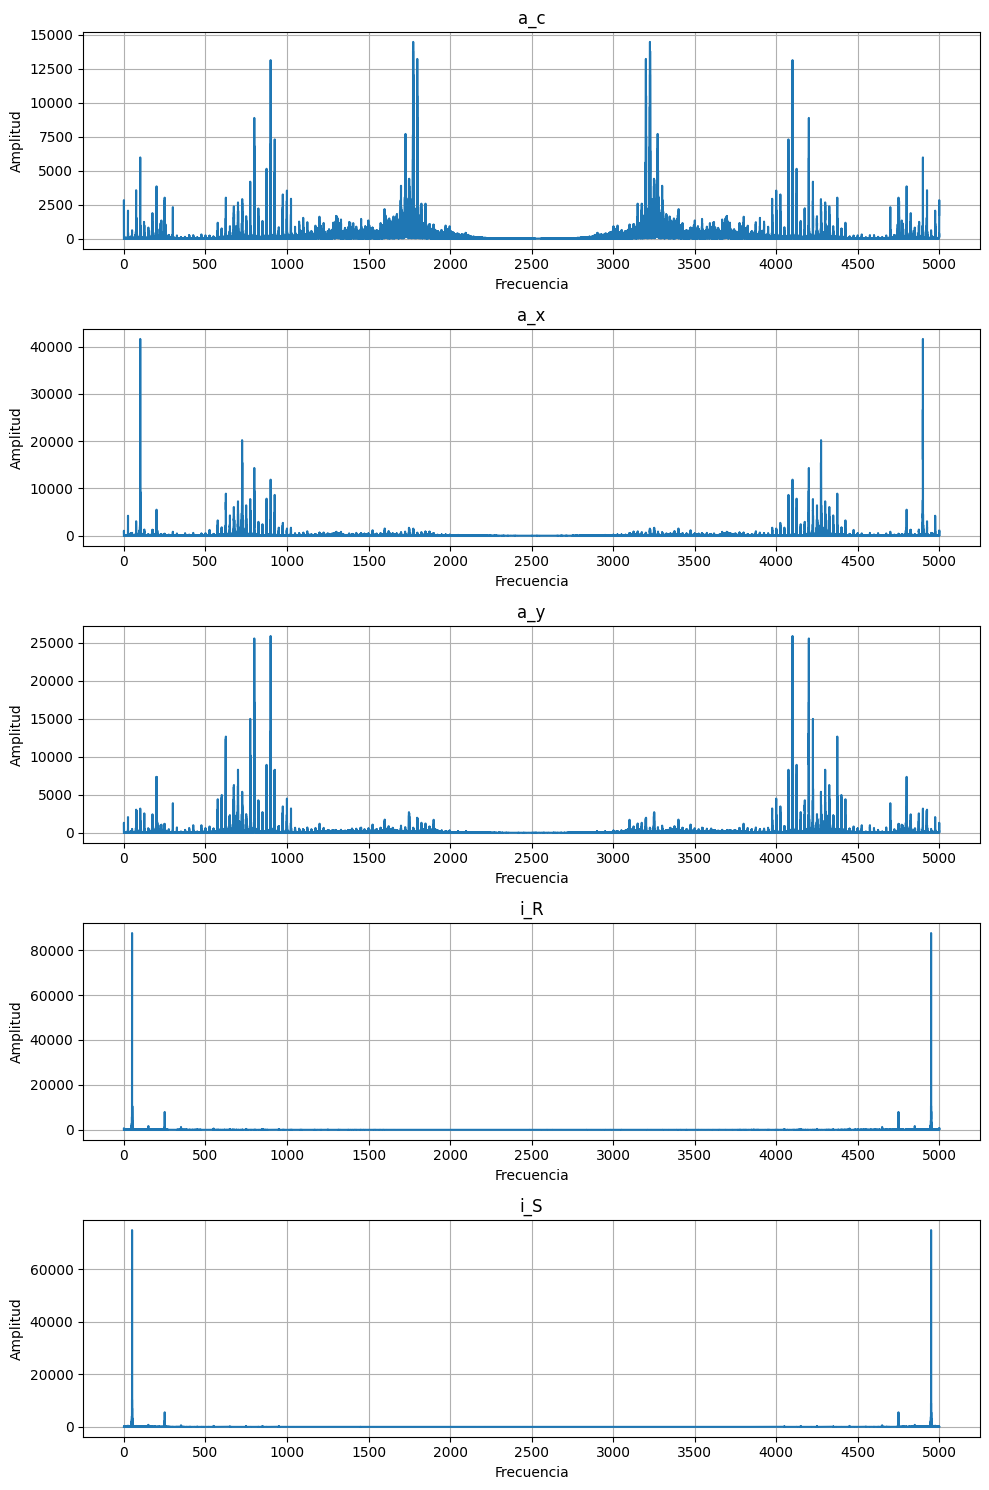

In [187]:
# Realizar la FFT de cada columna de la matriz X
fft_columns = np.fft.fft(Xn, axis=0)

# Crear una figura con 5 subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

# Generar los subplots
for i in range(5):
    axs[i].plot(ff,np.abs(fft_columns[:, i]))
    axs[i].set_title(nombresCaracteristicas[0,i][0])
    axs[i].set_xlabel('Frecuencia')
    axs[i].set_ylabel('Amplitud')
    axs[i].grid()
    axs[i].set_xticks(np.arange(0, fm + 1, 500))

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()

In [188]:
# Parámetros constructivos de las ventanas
N = 1000 # Tamaño de la ventana
delta = 100 # Desplazamiento de la ventana
bandasFreq = np.arange(0, 100, 25) # Bandas de frecuencia

f = np.arange(0, N, 1) * (fm/N) # Vector de frecuencias

# Inicialización de matriz de características
F = np.zeros(len(bandasFreq) * Xn.shape[1])
Fy = np.array([0])

# Método de enventanado
for k in range(0, Q-N, delta):
    # Obtención de arreglo con índices de la ventana
    idx = np.arange(k, k+N, 1)
    
    # Inicialización de vector de características
    carVector = np.zeros(len(bandasFreq) * Xn.shape[1]) # Número de bandas de frecuencia * número de características

    for i, f_banda in enumerate(bandasFreq):
        for j in range(Xn.shape[1]):
            # Seleccionar la ventana de la característica j
            v = Xn[idx, j]
            # Calcular la FFT
            V = np.abs(np.fft.fft(v))
            # Seleccionar los armónicos en la banda de frecuencia deseada
            armonicosSeleccionados = V[(f >= f_banda-5) & (f < f_banda + 5)]
            # Calcular el valor eficaz (RMS) y almacenarlo en el vector de características
            carVector[i * Xn.shape[1] + j] = np.sqrt(np.sum(armonicosSeleccionados**2) / len(armonicosSeleccionados))

    # Cálculo de la etiqueta de la ventana
    vy = Y_int[idx].mean()
    
    # Añadir vector de características a la matriz
    F = np.vstack((F, carVector))
    Fy = np.append(Fy, vy)

# Eliminar primera fila de la matriz de características
F = F[1:,:]
Fy = Fy[1:]

In [189]:
print(f"La matriz de características tiene {F.shape[0]} muestras y {F.shape[1]} mediciones")
print(f"La matriz de etiquetas tiene {Fy.shape[0]} muestras")

La matriz de características tiene 2090 muestras y 20 mediciones
La matriz de etiquetas tiene 2090 muestras


# Visualización con TSNE

In [193]:
# Crear un objeto TSNE
#tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne = TSNE(n_components=2,perplexity=200)

# Ajustar y transformar la matriz de características
F2D = tsne.fit_transform(F)

In [194]:
F2D.shape

(2090, 2)

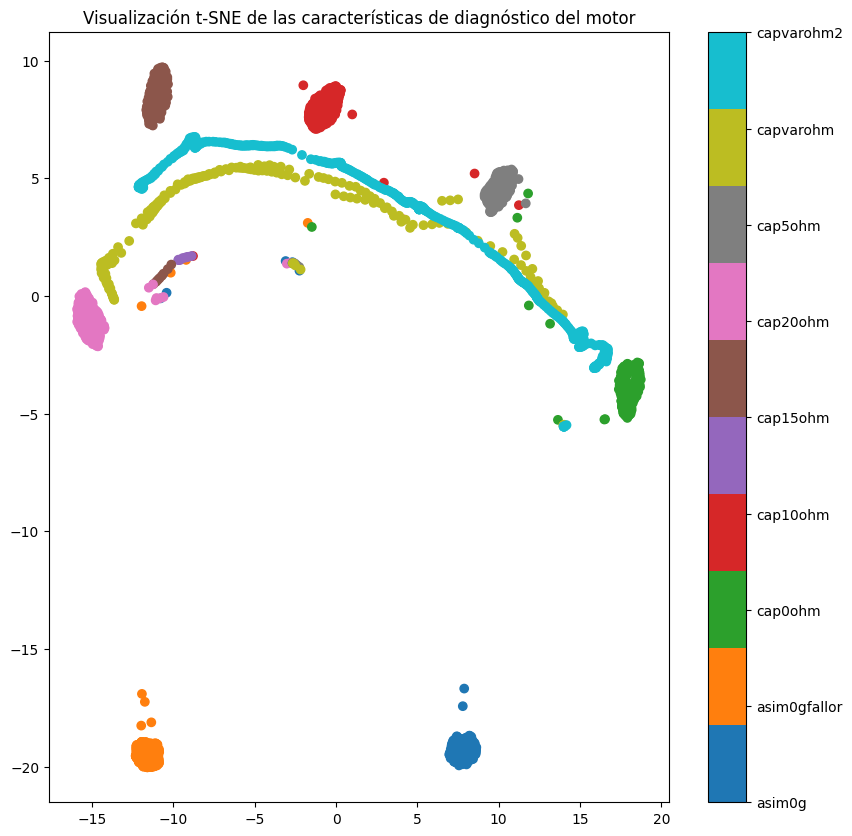

In [197]:
# Crear una figura
plt.figure(figsize=(10, 10))

# Generar un scatter plot
scatter = plt.scatter(F2D[:, 0], F2D[:, 1], c=Fy, cmap='tab10')
colorbar = plt.colorbar(scatter)
colorbar.set_ticks(np.arange(len(label_encoder.classes_)))
colorbar.set_ticklabels(label_encoder.inverse_transform(np.arange(len(label_encoder.classes_))))
plt.title('Visualización t-SNE de las características de diagnóstico del motor')
plt.show()